# Catch that asteroid with poliastro!

![poliastro](img/logo_text.svg)

### Juan Luis Cano - 2018-05-01 PyAstro18 @ Simons Foundation, NYC

# Who am I?

<img src="img/juanlu_esa.jpg" alt="Me!" width="400" style="float:right"></img>

* **Aerospace Engineer** with a passion for orbits 🛰
* Chair of the **Python España** non profit and co-organizer of **PyCon Spain** 🐍
  - Come to Málaga! https://2018.es.pycon.org/
* **Software Developer** at **Satellogic** 🌍
* Free Software advocate and Python enthusiast 🕮
* Hard Rock lover 🎸

Follow me! https://github.com/Juanlu001/

<div style="clear:both"></div>

# Introduction to poliastro

<img src="img/logo_text.svg" alt="poliastro" width="500" style="float:right"></img>

> poliastro is a collection of Python functions useful in Astrodynamics and Orbital Mechanics, focusing on interplanetary applications. 

* **Pure Python**, accelerated with **numba**
* **MIT license** (permissive)
* Physical units, astronomical scales and more, thanks to Astropy
* Conversion between several orbit representations
* Analytical and numerical propagation
* Cool documentation 🚀 http://docs.poliastro.space/
* Latest version 0.9.0 released a week ago http://docs.poliastro.space/en/v0.9.0/changelog.html#poliastro-0-9-0-2018-04-25

<div style="clear:both"></div>

## Brief history

* _2013_: First version: Octave + FORTRAN + Python
* _2014_: Refactor of the API, much friendlier
* _2015_: Replace FORTRAN algorithms by Python + numba 🚀
* _2016_: Izzo algorithm (Lambert's problem), 6th ICATT @ ESA
* _2017_: Summer of Code in Space (SOCIS), OpenAstronomy & Astropy membership, 1st OSCW @ ESOC
* _2018_: Google Summer of Code (GSOC), #PyAstro18 @ Simons Fndn, expansion into the industry

## ~~Why another...~~ How does it compare to...?

* **Orekit**: not restricted to Earth orbits, more general
* **NASA SPICE**: more lightweight, focused on interactive use, not backed by NASA 😁

In [1]:
import matplotlib.pyplot as plt
plt.ion()

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=False)

from astropy import units as u
from astropy.time import Time

In [2]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit

In [3]:
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v, Time.now())
ss

7283 x 10293 km x 153.2 deg orbit around Earth (♁)

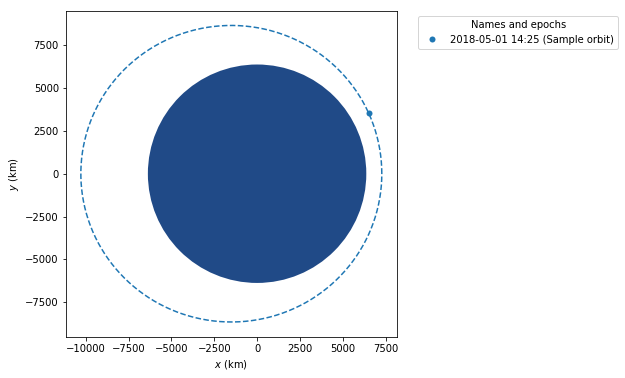

In [4]:
from poliastro.plotting import plot, plot3d
plot(ss, label="Sample orbit");

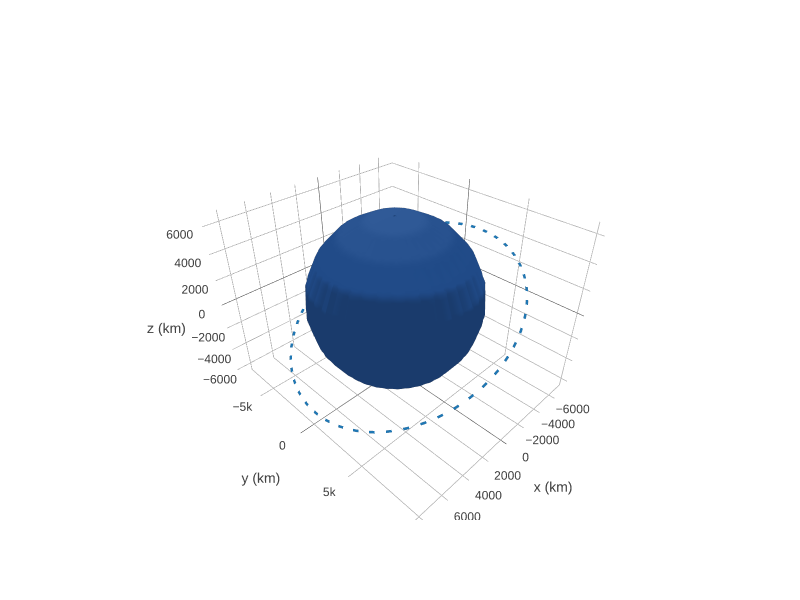

In [5]:
plot3d(ss, label="Sample orbit");

## External data

* Planetary ephemerides
  - SPICE kernels
* Near Earth Objects (NEOs)
  - NeoWs https://api.nasa.gov/neo/?api_key=DEMO_KEY
  - DASTCOM5 database ftp://ssd.jpl.nasa.gov/pub/ssd/README.txt

In [6]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [7]:
Orbit.from_body_ephem(Earth)

1 x 1 AU x 23.4 deg orbit around Sun (☉)

In [8]:
from poliastro.neos import neows

florence = neows.orbit_from_name("Florence")
florence

1 x 3 AU x 22.1 deg orbit around Sun (☉)

In [9]:
from poliastro.neos import dastcom5

halley_1835 = dastcom5.orbit_from_name('1P')[30]
halley_1835

1 x 35 AU x 162.3 deg orbit around Sun (☉)

In [10]:
from poliastro.plotting import OrbitPlotter
from poliastro.bodies import Mercury, Venus, Earth, Mars

(-300000000.0, 300000000.0)

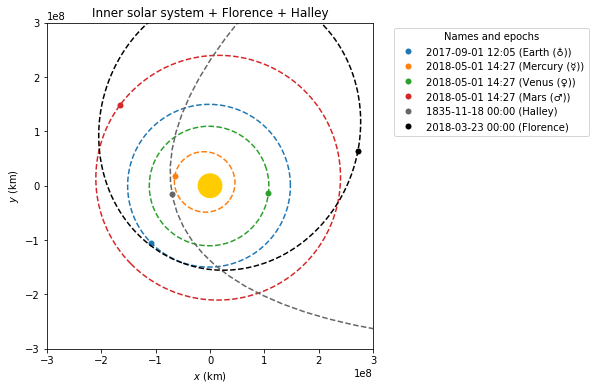

In [11]:
frame = OrbitPlotter()

# Florence close approach
frame.plot(Orbit.from_body_ephem(Earth, epoch=Time("2017-09-01 12:05:50", scale="tdb")), label=Earth)

for planet in Mercury, Venus, Mars:
    frame.plot(Orbit.from_body_ephem(planet), label=planet)

frame.plot(halley_1835, label='Halley', color='#666666')
frame.plot(florence, label='Florence', color='#000000')

plt.title("Inner solar system + Florence + Halley")
plt.xlim(-.3e9, .3e9)
plt.ylim(-.3e9, .3e9)

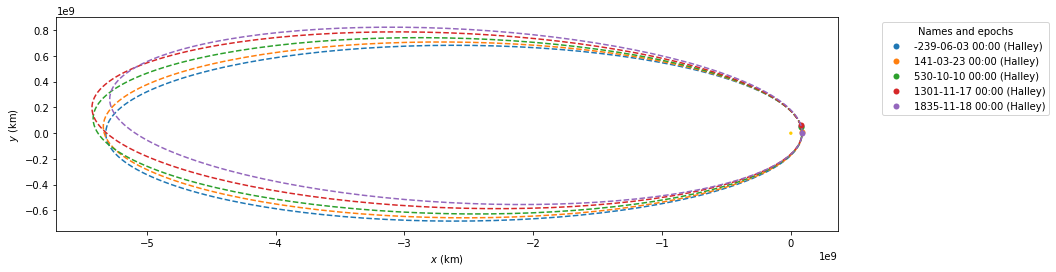

In [12]:
halleys = dastcom5.orbit_from_name('1P')

frame = OrbitPlotter(num_points=200)
frame.plot(halleys[0], label='Halley')
frame.plot(halleys[5], label='Halley')
frame.plot(halleys[10], label='Halley')
frame.plot(halleys[20], label='Halley')
frame.plot(halleys[30], label='Halley')

## Core algorithms

* Analytical propagation, aka Kepler's problem (_Battin universal variables approach_, _mean anomaly evolution_)
* Numerical propagation (_Cowell's method_)
* Boundary-value problem, aka Lambert's problem (_Izzo algorithm with multiple revolution_)
* Orbital maneuvers (_Hohmann's transfer, bielliptic transfer_)

In [13]:
from poliastro.twobody.propagation import propagate, cowell
from poliastro.util import norm, time_range

from numba import njit

@njit
def accel(t0, state, k):
    """Constant acceleration aligned with the velocity. """
    v_vec = state[3:]
    norm_v = (v_vec * v_vec).sum() ** .5
    return 1e-5 * v_vec / norm_v

def custom_propagator(orbit, tof, rtol, accel=accel):
    # Workaround for https://github.com/poliastro/poliastro/issues/328
    if tof == 0:
        return orbit.r.to(u.km).value, orbit.v.to(u.km / u.s).value
    else:
        # Use our custom perturbation acceleration
        return cowell(orbit, tof, rtol, ad=accel)

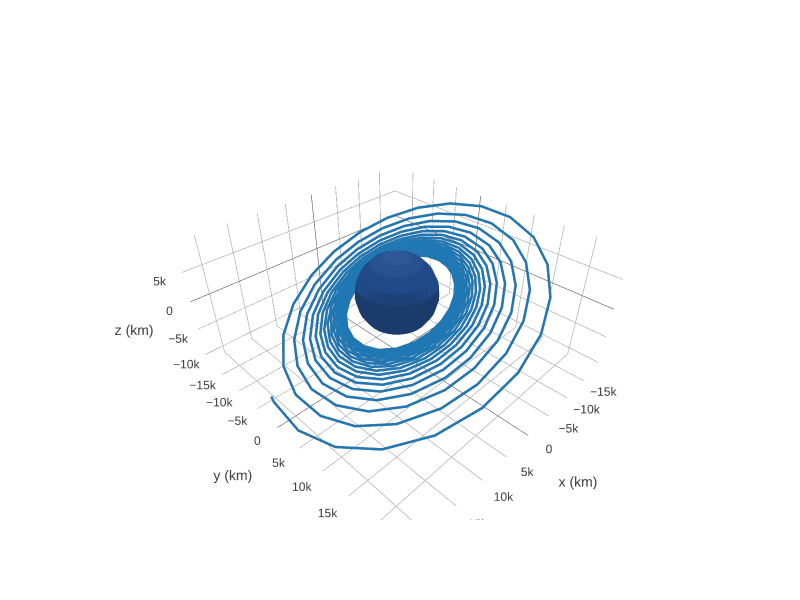

In [14]:
from poliastro.plotting import OrbitPlotter3D

frame = OrbitPlotter3D()

_, rr_earth = ss.sample(
   time_range(ss.epoch, end=ss.epoch + 3 * u.day, periods=300),
   method=custom_propagator
)

frame.set_attractor(Earth)
frame.plot_trajectory(rr_earth, label=Earth)
frame.show()

# Challenges

## Validation

> Unit testing a function with clear expectations is trivial. What are my expectations on numerical algorithms?

The wrooooooooooooooong way:

In [15]:
def sinc(x):
    return np.sin(x) / x

In [16]:
import pytest

In [17]:
@pytest.mark.parametrize("x", [0, 1, 10])
def test_sinc(x):
    assert sinc(x) == np.sin(x) / x

In [18]:
0.1 + 0.2 == 0.3

False

In [19]:
0.2 + 0.3 == 0.5

True

What's the good way?

* Doing floating point comparisons right is only the first step: you have to **validate against external data or software**
* How much precision do you ask for?
* The changes in precision are a result of bad data, or worse algorithms? How do you even track _improvements_?

### External data (short summary)

* Nobody cares

* Those who care, don't share it

* Those who share, do it with 1 decimal place (true story)

* Those who share with 16 decimal places, don't describe how it was obtained (i.e. release the source)

* Those who release the source, make it impossible to compile

### External software

* Sometimes commercial
* Is it validated itself? (See above)
* It is often difficult to reproduce the exact setting and algorithms, most of the times because your commercial software is much more complex

![Shrug](img/shrugging-guy.jpg)

...If you're really interested, go read my Final Masters Project: https://github.com/juanlu001/pfc-uc3m

## Performant and "for humans"

* _Yes, Python is slow_ (compared to compiled languages)
* Some algorithms cannot easily be vectorized (i.e. replaced by NumPy)
* And even if you can, vectorized code can be impossible to read
* I don't like Cython (messy, impossible to debug, I don't know C)
* _numba helps only with Fortran-esque code_ (forget about closures or introspection)

![Too smart](img/too_smart.png)

So... let's make our code Fortran-esque!

<img src="img/architecture.svg" alt="Architecture" width="500" style="float:right"></img>

High level API:

* Supports mixed units and time scales, figures out the rest
* Easy to use and impossible to get wrong
* **Slow**

Dangerous™ algorithms:

* **Fast** (easy to accelerate with numba or Cython)
* Only cares about numbers, makes assumptions on units (SI, TBD)
* **You can mess it up**

<div style="clear:both"></div>

### Main obstacle: `astropy.units` performance

* `astropy.units` does a lot of introspection, which makes it slow
* To maintain performance, I have to remove slow code from loops
* This leads to some sub-optimal API choices

## Community building

> I believe the choice of license is an important one, and I advocate a BSD-style license. **In my experience, the most important commodity an open source project needs to succeed is users.**
>
> -- John Hunter † http://nipy.org/nipy/faq/johns_bsd_pitch.html

* Sometimes, language wins over performance.
* Sometimes, documentation wins over features.
* Sometimes, marketing wins over quality.

_Go find your users!_

# _Per Python ad astra!_ 🚀

* Slides: https://github.com/poliastro/pyastro18-talk
* poliastro chat: https://riot.im/app/#/room/#poliastro:matrix.org
* Twitter: https://twitter.com/poliastro_py

## Muchas gracias :)

![Rocket](img/rocket.jpg)